In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import sklearn.datasets
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from xgboost import plot_importance

import re
import os
import glob
from datetime import datetime as dt
import warnings
from time import sleep
from tqdm import tqdm

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

#### Read the input data conditioned for ML

In [2]:
data_path = "../03_Data_Cleaning/data/*.csv"
listing = glob.glob(data_path)
latest_file = max(listing, key=os.path.getctime)
print(f'The file selected is: {latest_file}')

# Create the input DF
df = pd.read_csv(latest_file)
df

The file selected is: ../03_Data_Cleaning/data\ML_data_Houston_TX_Houses_merged_2023_1_1_12_5.csv


,Lat,Lng,Price,Bedrooms,Bathrooms,constructedArea,zipCode,hasGarage,hasPool,hasCooling,hasView,yearBuilt,stories,parkingSpaces,annualHOI,schoolElemRating,schoolElemDist,schoolMidRating,schoolMidDist,schoolHighRating,schoolHighDist,priceIncreased,priceDiff,days,lotAreaSQFT
0,29.603600,-95.485405,276000,3,2,3612,77489,1,0,1,0,1971,2,2,1159,6,0.5,3,1.3,2,1.1,1,31000,1213,8764.272
1,29.600388,-95.488210,220000,3,2,1270,77489,1,0,1,0,1972,1,1,924,6,0.3,3,1.3,2,1.0,1,65100,503,7884.360
2,29.595436,-95.485880,230000,4,2,1765,77489,1,0,1,0,1974,1,2,966,6,0.3,3,1.0,2,0.6,1,115275,5140,7148.196
3,29.597320,-95.492690,225000,3,2,1444,77489,1,0,1,0,1978,1,2,945,6,0.1,3,1.4,2,1.0,1,56000,824,7731.900
4,29.592060,-95.489050,246500,3,2,1738,77489,1,0,1,0,1978,1,2,1035,6,0.3,3,1.0,2,0.6,1,41500,6810,8062.956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4494,29.808900,-95.408710,669900,3,3,2576,77008,1,0,1,0,2022,2,2,2814,5,0.3,5,0.7,5,1.3,1,404900,3993,3275.000
4495,29.775753,-95.407600,519000,3,4,2513,77007,1,0,1,0,2006,3,2,2180,8,1.2,6,1.6,5,1.5,1,522400,4145,2330.460
4496,29.685492,-95.371700,550000,1,2,5160,77021,1,0,1,0,1952,1,2,2310,2,0.3,3,0.6,2,2.5,1,375000,4219,15000.000
4497,29.778660,-95.415340,450000,3,4,2148,77007,1,0,1,0,2007,3,2,1890,4,1.0,6,2.0,3,2.7,0,0,0,2051.676


#### Perform some additional pre-processing

In [3]:
# Remove outlier price:
df = df[df['Price'] >= 200000] 

# Average the school rates and distances
df['avgSchoolRating'] = df[['schoolElemRating', 'schoolMidRating', 'schoolHighRating']].mean(axis=1)
df['avgSchoolDist'] = df[['schoolElemDist', 'schoolMidDist', 'schoolHighDist']].mean(axis=1)

# Remove unwanted features
df = df.drop(['annualHOI', 'days', 'priceDiff', 'priceIncreased', 'Lat', 'Lng', 'schoolElemRating', 'schoolMidRating', 'schoolHighRating', 'schoolElemDist', 'schoolMidDist', 'schoolHighDist'], axis=1)

#### Perform basic QC on the input DF

In [4]:
# Check if there are any null values
df.isnull().sum()

Price              0
Bedrooms           0
Bathrooms          0
constructedArea    0
zipCode            0
hasGarage          0
hasPool            0
hasCooling         0
hasView            0
yearBuilt          0
stories            0
parkingSpaces      0
lotAreaSQFT        0
avgSchoolRating    0
avgSchoolDist      0
dtype: int64

In [5]:
# Get statistics
df.describe()

,Price,Bedrooms,Bathrooms,constructedArea,zipCode,hasGarage,hasPool,hasCooling,hasView,yearBuilt,stories,parkingSpaces,lotAreaSQFT,avgSchoolRating,avgSchoolDist
count,4498.000000,4498.000000,4498.000000,4498.000000,4498.000000,4498.000000,4498.000000,4498.000000,4498.000000,4498.000000,4498.000000,4498.000000,4498.000000,4498.000000,4498.000000
mean,401394.400178,3.400845,2.836149,2159.437972,77070.781903,0.834593,0.062250,0.957759,0.010671,1993.488662,1.689418,1.744775,7290.854534,4.261820,1.718067
std,156990.084336,0.701705,0.878959,709.985274,81.286338,0.371589,0.241636,0.201161,0.102761,28.984694,0.728882,0.800961,8653.115673,1.374233,1.190225
min,200000.000000,1.000000,1.000000,480.000000,77003.000000,0.000000,0.000000,0.000000,0.000000,1888.000000,1.000000,0.000000,1240.000000,2.000000,0.166667
25%,280000.000000,3.000000,2.000000,1681.000000,77022.000000,1.000000,0.000000,1.000000,0.000000,1970.000000,1.000000,2.000000,4229.676000,3.000000,0.933333
50%,364000.000000,3.000000,3.000000,2020.000000,77057.000000,1.000000,0.000000,1.000000,0.000000,2003.000000,2.000000,2.000000,6993.558000,4.000000,1.333333
75%,469990.000000,4.000000,3.000000,2528.750000,77084.000000,1.000000,0.000000,1.000000,0.000000,2022.000000,2.000000,2.000000,8158.788000,5.333333,1.966667
max,900000.000000,8.000000,7.000000,6793.000000,77598.000000,1.000000,1.000000,1.000000,1.000000,2023.000000,5.000000,9.000000,174240.000000,9.000000,5.100000


<AxesSubplot:>

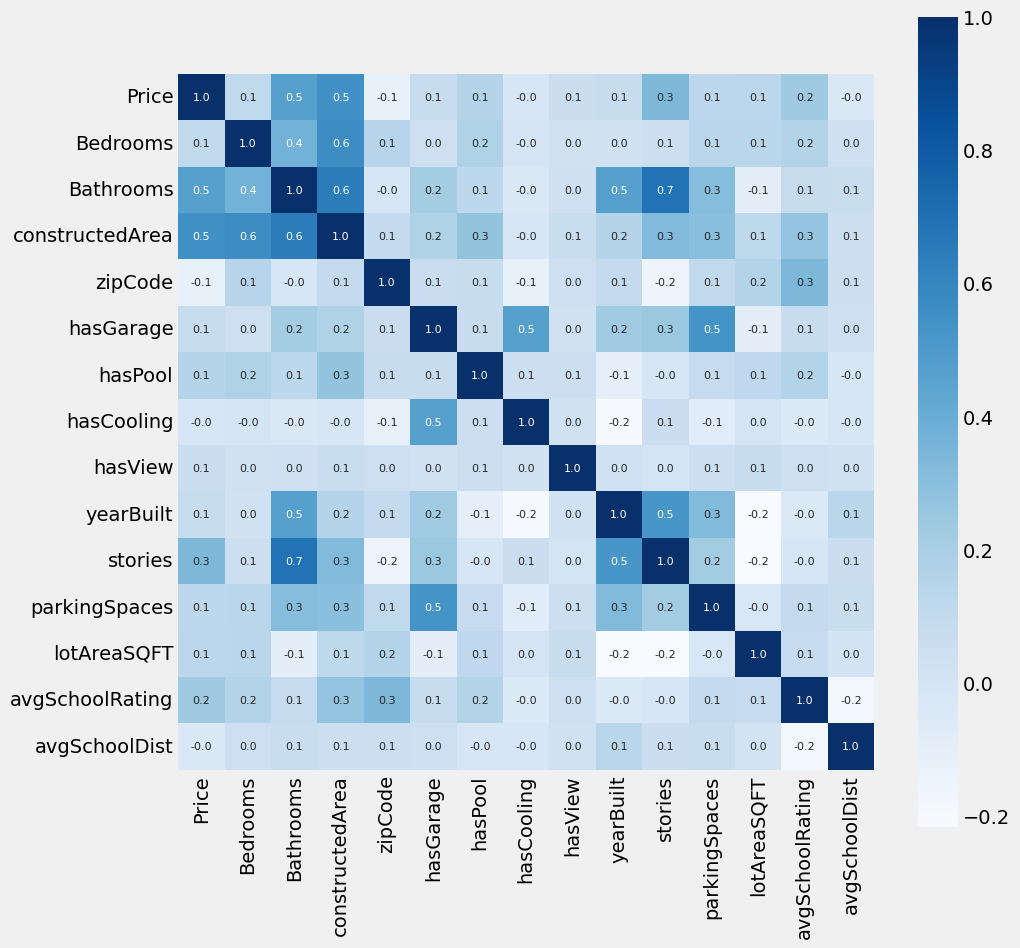

In [15]:
# Heat map
# A heat map shows the correlation between the input data columns
# There are 2 types of correlation:
# Positive: As the magnitude of a feature increases, the magnitude of a correlated feature increases
# Negative: As the magnitude of a feature increases, the magnitude of a correlated feature decreases
correlation = df.corr()
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,10))
sns.heatmap(correlation, cbar=True, square=True, fmt='.1f', annot=True, annot_kws={'size':8}, cmap='Blues')

#### Get the features and the target column

In [7]:
# Create a new DataFrame that holds only the cryptocurrencies names.
# X = Features, y = target
X = df.drop('Price', axis=1)
y = df[["Price"]]

#### Split the data for training and testing

In [8]:
# Use 20% of data for testing. Use a random_state = 2 to be able to reproduce the splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)
print(X.shape, X_train.shape, X_test.shape)

(4498, 14) (3598, 14) (900, 14)


#### Model Training

In [9]:
# Load the model (XGBoost Regressor)
model = XGBRegressor()

# Train the model with the training data
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

#### Make predictions using the test data

In [10]:
y_test_predicted = model.predict(X_test)

# Calculate the R squared error
error_r2 = metrics.r2_score(y_test, y_test_predicted)

# Calculate the mean absolute error
error_ma = metrics.mean_absolute_error(y_test, y_test_predicted)

print(f'R squared error: {error_r2} (should be close to 1)')

R squared error: 0.7565146337013343 (should be close to 1)


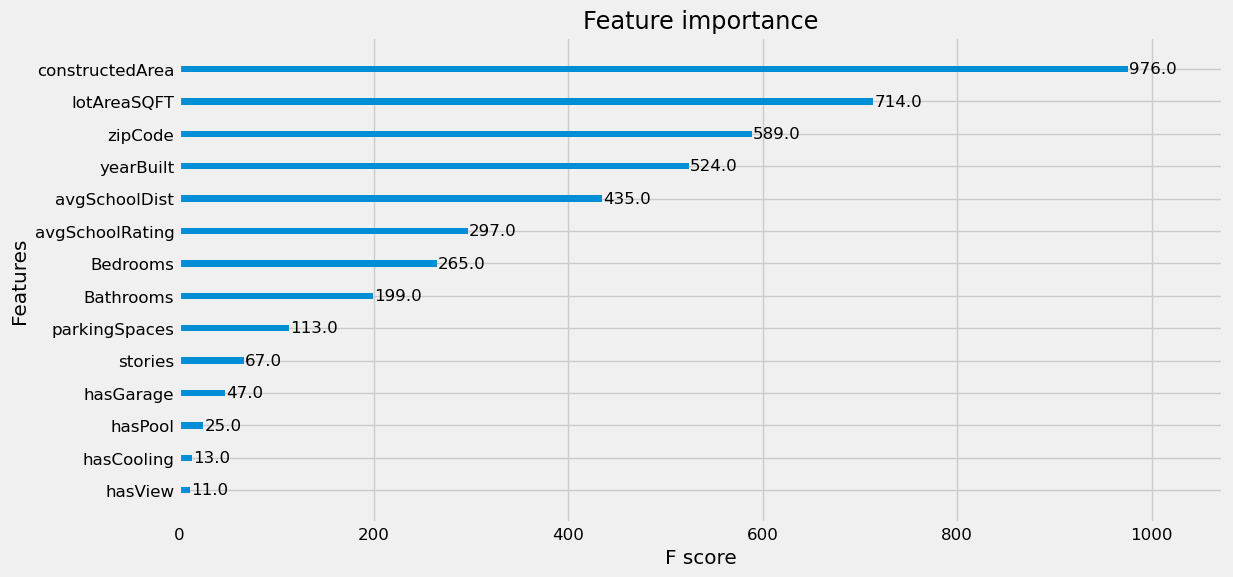

In [11]:
# Plot the features importance
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=(12,6))
plot_importance(model, ax=ax)
plt.show();

In [12]:
# Display the actual price vs the predicted price
y_test_df = y_test.reset_index(drop=True)
y_test_df = y_test_df.rename(columns = {'Price':'Actual_Price'})

y_pred_df = pd.DataFrame(y_test_predicted, columns = ['Predicted_Price'])
y_pred_df = y_pred_df['Predicted_Price'].apply(np.ceil).astype('int')

# Display the actual and the predicted prices side by side
df_prices = pd.concat([y_test_df, y_pred_df], axis=1)
df_prices

,Actual_Price,Predicted_Price
0,250000,259077
1,260000,285600
2,244990,274389
3,825000,871168
4,599900,616633
...,...,...
895,474500,445909
896,300045,266905
897,399900,354737
898,599000,539343


In [ ]:
# # Scatter Plot using test data
#plt.scatter(y_test_df, y_pred_df)
#plt.xlabel('Actual Price')
#plt.ylabel('Predicted Price')
#plt.title('HPP Scatter Plot: Test Data')
#plt.show()

## Linear regression line fit

In [13]:
# Format the data to meet the requirements of the Scikit-learn library
X = df_prices.Actual_Price.values.reshape(-1, 1)
y = df_prices.Predicted_Price

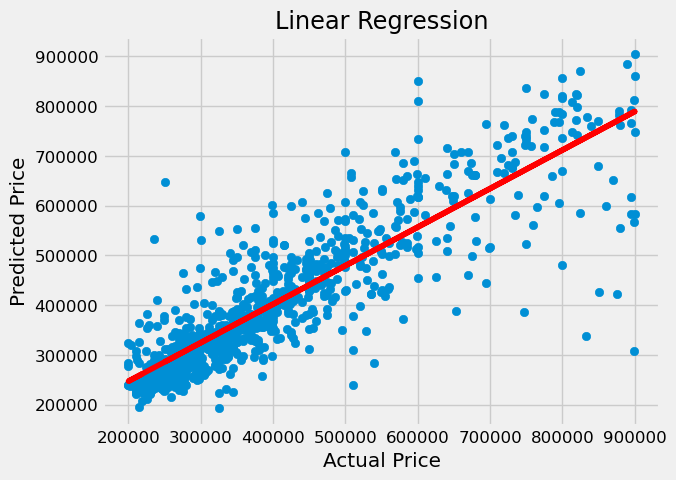

In [14]:
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Plot the predictions as a red line against the data points
plt.scatter(X, y)
plt.plot(X, y_pred, color='red')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Linear Regression')
plt.show()

In [ ]:
# Linear regression formula: y = mx + b
print(f'y = {model.coef_[0]}x + {model.intercept_}')